# Hearbet Sound Anomaly Detector - Training

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.transforms as T
from torchmetrics import Precision

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
torch.__version__

'2.1.1+cu121'

In [3]:
torch.cuda.is_available()

True

## Creating Pandas dataframe

In [4]:
AUDIO_DIR = Path('../unzipped_data/')

def list_files():
    for file in AUDIO_DIR.glob('**/*.wav'):
        yield file.as_posix()

def create_dataframe():
    data_files = []
    for filename in list_files():
        if filename.find('artifact')>-1:
            data_files.append((filename, 'artifact'))
        if filename.find('extrahls')>-1:
            data_files.append((filename, 'extrahls'))
        if filename.find('extrastole')>-1:
            data_files.append((filename, 'extrastole'))
        if filename.find('murmur')>-1:
            data_files.append((filename, 'murmur'))
        if filename.find('normal')>-1:
            data_files.append((filename, 'normal'))

    return pd.DataFrame(data_files, columns=('fname', 'label'))

In [5]:
dataframe = create_dataframe()

## Custom Dataset and DataLoaders

In [6]:
labels = dataframe.label.unique()
dict(zip(labels, range(len(labels))))

{'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

In [7]:
class AudioDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, audio_length: float, target_sample_rate: int) -> None:
        self.dataframe = dataframe
        self.audio_length = audio_length
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * audio_length
        self.labels = dataframe['label'].values
        self.filenames = dataframe['fname'].values
        self.class_indices = {'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index) -> dict:
        waveform, sample_rate = torchaudio.load(self.filenames[index])
        waveform = torch.mean(waveform, axis=0)

        if sample_rate!=self.target_sample_rate:
            resampler = T.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        if waveform.shape[0] > self.num_samples:
            waveform = waveform[:self.num_samples]
        else:
            waveform = F.pad(waveform, (0, self.num_samples - waveform.shape[0]))
        melspectrgoram = T.MelSpectrogram(n_fft=128, n_mels=128, hop_length=128)
        melspec = melspectrgoram(waveform)

        class_idx = self.class_indices[self.labels[index]]

        return torch.stack([melspec]), class_idx

In [8]:
SEED: int = 42
AUDIO_LENGTH: int = 15
TARGET_SAMPLE_RATE: int = 4000

audio_dataset = AudioDataset(dataframe, AUDIO_LENGTH, TARGET_SAMPLE_RATE)
generator = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [.7, .3], generator)

In [9]:
print('Train:', len(train_dataset.indices), '-- Test:', len(test_dataset.indices))

Train: 410 -- Test: 175


## Training

### Architecture

In [10]:
# NUM_CLASSES: 5
# INPUT_SHAPE: (128, 469, 1)

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 4)),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=(3, 4)),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=(2, 3), stride=(2, 3)),
            nn.ReLU()
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=(3, 4)),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.dense_layers = nn.Sequential(
            nn.Linear(64*28*47, 100),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Linear(100, 5)
        )

    def forward(self, X):
        X = self.conv_block1(X)
        X = self.conv_block2(X)
        X = self.conv_block3(X)
        X = X.view(-1, 64*28*47)
        X = self.dense_layers(X)
        return X

In [11]:
print(Network())

Network(
  (conv_block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): MaxPool2d(kernel_size=(2, 3), stride=(2, 3), padding=0, dilation=1, ceil_mode=False)
    (3): ReLU()
  )
  (conv_block3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (dense_layers): Sequential(
    (0): Linear(in_features=84224, out_features=100, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=5, bias=True)
  )


### Training model

In [12]:
from typing import Callable, Dict, List, Tuple

class HearbetDetectorTrainer:
    def __init__(self, model, device: str) -> None:
        if not isinstance(model, nn.Module):
            raise ValueError('The provided model is not an instance of nn.Module')

        self.__device = device
        self.__precision_fn: Callable = Precision(task = 'multiclass', num_classes = 5).to(device)
        self.__model = model.to(device)
        self.__model.apply(self.__init_weights)

    def __init_weights(self, module) -> None:
        if isinstance(module, (nn.Linear, nn.Conv2d)):
            torch.nn.init.xavier_uniform_(module.weight)
            module.bias.data.fill_(0.01)

    def __inner_loop(self, specs, labels, loss_function: torch.nn.Module, is_train: bool) -> Tuple:
        specs, labels = specs.to(self.__device), labels.to(self.__device)
        outputs = self.__model(specs)
        loss = loss_function(outputs, labels)
        loss_value = loss.cpu().item()
        if is_train:
            loss.backward()
        return loss_value, self.__precision_fn(outputs, labels).item()

    def __train_step(self, optimizer: torch.optim.Optimizer, train_loader: torch.utils.data.DataLoader, loss_function: torch.nn.Module) -> Tuple[float, float]:
        train_loss, train_precision = 0, 0

        self.__model.train()
        for specs, labels in train_loader:
            optimizer.zero_grad()
            loss_value, precision_value = self.__inner_loop(specs, labels, loss_function, is_train = True)
            train_loss += loss_value
            train_precision += precision_value
            optimizer.step()

        length_train_loader = len(train_loader)

        return train_loss/length_train_loader, train_precision/length_train_loader

    def __test_step(self, val_loader: torch.utils.data.DataLoader, loss_function: torch.nn.Module) -> Tuple[float, float]:
        val_precision, val_loss = 0, 0

        self.__model.eval()
        with torch.inference_mode():
            for specs, labels in val_loader:
                loss_value, precision_value = self.__inner_loop(specs, labels, loss_function, is_train = False)
                val_loss += loss_value
                val_precision += precision_value

        length_val_loader = len(val_loader)

        return val_loss/length_val_loader, val_precision/length_val_loader

    def fit(self,
            loss_function: torch.nn.Module,
            optimizer: torch.optim.Optimizer,
            epochs: int,
            batch_size: int,
            training_set,
            validation_set) -> Dict[str, List]:

        train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(validation_set, batch_size=batch_size)

        print('Training on', self.__device)

        report_dict: Dict =  {
            'loss': [],
            'precision': [],
            'val_loss': [],
            'val_precision': []
        }

        for epoch in range(epochs):
            train_loss, train_precision = self.__train_step(optimizer, train_loader, loss_function)
            val_loss, val_precision = self.__test_step(val_loader, loss_function)

            report_dict['loss'].append(train_loss)
            report_dict['precision'].append(train_precision)
            report_dict['val_loss'].append(val_loss)
            report_dict['val_precision'].append(val_precision)

            print('Epoch: {} | Loss: {:.4f} - Precision: {:.4f} - Val loss: {:.4f} - Val precision: {:.4f}'
                  .format(epoch+1, train_loss, train_precision, val_loss, val_precision))

        return report_dict

Calculating weights to fix unbalanced classes:

In [15]:
train_df = dataframe.iloc[train_dataset.indices]
weights = round(len(train_df)/(5*train_df.label.value_counts()), 2)
print(weights)
print(list(weights.values))

label
normal        0.34
murmur        0.85
extrastole    2.83
artifact      2.93
extrahls      5.86
Name: count, dtype: float64
[0.34, 0.85, 2.83, 2.93, 5.86]


In [14]:
%%time

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Network()

hearbetDetectorNetwork = HearbetDetectorTrainer(model=model, device = device)

class_weights = torch.tensor([0.34, 0.85, 2.83, 2.93, 5.86]).to(device)
loss_function = nn.CrossEntropyLoss(weight = class_weights)
EPOCHS: int = 30
BATCH_SIZE: int = 4
LEARNING_RATE: float = 0.0001
optimizer = torch.optim.SGD(params = model.parameters(), lr = LEARNING_RATE, momentum = 0.9)

history = hearbetDetectorNetwork.fit(loss_function = loss_function,
                                     optimizer = optimizer,
                                     epochs = EPOCHS,
                                     batch_size = BATCH_SIZE,
                                     training_set = train_dataset,
                                     validation_set = test_dataset)

Training on cuda


c:\Users\Erick\miniconda3\envs\heartbet-sound-anomaly-detector-py311\Lib\site-packages\torchaudio\functional\functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (65) may be set too low.
  warnings.warn(


Epoch: 1 | Loss: 1.5107 - Precision: 0.5146 - Val loss: 1.1629 - Val precision: 0.6326
Epoch: 2 | Loss: 0.8720 - Precision: 0.6359 - Val loss: 1.0108 - Val precision: 0.6326
Epoch: 3 | Loss: 0.8158 - Precision: 0.6529 - Val loss: 1.1481 - Val precision: 0.6269
Epoch: 4 | Loss: 0.7146 - Precision: 0.7112 - Val loss: 1.1101 - Val precision: 0.6439
Epoch: 5 | Loss: 0.6836 - Precision: 0.7451 - Val loss: 1.1492 - Val precision: 0.6269
Epoch: 6 | Loss: 0.5936 - Precision: 0.7670 - Val loss: 1.2449 - Val precision: 0.6269
Epoch: 7 | Loss: 0.5805 - Precision: 0.7597 - Val loss: 1.3507 - Val precision: 0.6326
Epoch: 8 | Loss: 0.5070 - Precision: 0.8010 - Val loss: 1.1790 - Val precision: 0.6269
Epoch: 9 | Loss: 0.4770 - Precision: 0.8131 - Val loss: 1.3783 - Val precision: 0.6155
Epoch: 10 | Loss: 0.4077 - Precision: 0.8180 - Val loss: 1.4941 - Val precision: 0.6155
Epoch: 11 | Loss: 0.3883 - Precision: 0.8374 - Val loss: 1.6401 - Val precision: 0.6098
Epoch: 12 | Loss: 0.4111 - Precision: 0.8

In [16]:
def plot_loss_curves(history: Dict[str, List]):
    _, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))

    epochs = range(1, len(history['loss']) + 1)

    ax1.set_title('Loss')
    ax1.plot(epochs, history['loss'], label='Training')
    ax1.plot(epochs, history['val_loss'], label='Validation')
    ax1.legend()

    ax2.set_title('Precision')
    ax2.plot(epochs, history['precision'], label='Training')
    ax2.plot(epochs, history['val_precision'], label='Validation')
    ax2.legend()

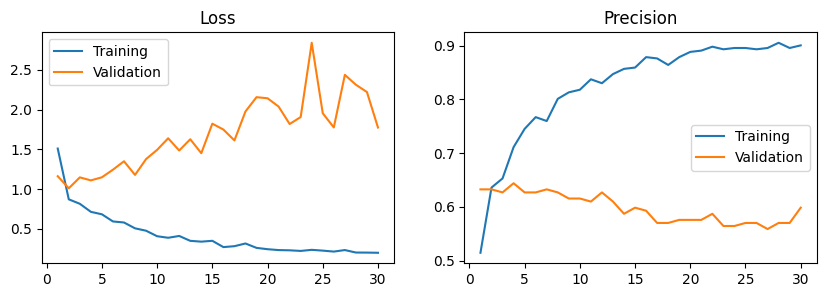

In [17]:
plot_loss_curves(history)

## Training with Pretrained model

In [18]:
class AudioDataset_1(Dataset):
    def __init__(self, dataframe: pd.DataFrame, audio_length: float, target_sample_rate: int) -> None:
        self.dataframe = dataframe
        self.audio_length = audio_length
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate * audio_length
        self.labels = dataframe['label'].values
        self.filenames = dataframe['fname'].values
        self.class_indices = {'artifact': 0, 'extrahls': 1, 'murmur': 2, 'normal': 3, 'extrastole': 4}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index: int) -> Tuple:
        waveform, sample_rate = torchaudio.load(self.filenames[index])
        waveform = torch.mean(waveform, axis=0)

        if sample_rate!=self.target_sample_rate:
            resampler = T.Resample(sample_rate, self.target_sample_rate)
            waveform = resampler(waveform)

        if waveform.shape[0] > self.num_samples:
            waveform = waveform[:self.num_samples]
        else:
            waveform = F.pad(waveform, (0, self.num_samples - waveform.shape[0]))
        melspectrgoram = T.MelSpectrogram(n_fft=128, n_mels=128, hop_length=128)
        melspec = melspectrgoram(waveform)

        class_idx = self.class_indices[self.labels[index]]

        return torch.stack([melspec]).expand(3, -1, -1), class_idx

In [19]:
SEED: int = 42
AUDIO_LENGTH: int = 15
TARGET_SAMPLE_RATE: int = 4000

audio_dataset = AudioDataset_1(dataframe, AUDIO_LENGTH, TARGET_SAMPLE_RATE)
generator = torch.Generator().manual_seed(SEED)
train_dataset, test_dataset = torch.utils.data.random_split(audio_dataset, [.7, .3], generator)

In [20]:
dino_vitb8 = torch.hub.load('facebookresearch/dino:main', 'dino_vitb8')

Using cache found in C:\Users\Erick/.cache\torch\hub\facebookresearch_dino_main


In [44]:
for params in dino_vitb8.parameters():
    params.requires_grad = False

dino_vitb8.head = nn.Sequential(nn.Linear(dino_vitb8.embed_dim,5))

In [28]:
# NUM_CLASSES: 5
# INPUT_SHAPE: (128, 469, 1)

class Network(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.__dino_vitb8 = torch.hub.load_state_dict_from_url('https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth')
        self.__model = nn.Sequential(
            nn.Linear(self.__dino_vitb8.embed_dim, 5)
        ).load_state_dict(self.__dino_vitb8)

    def forward(self, input):
        logits = self.__model(input)
        return logits

In [29]:
%%time

device: str = 'cuda' if torch.cuda.is_available() else 'cpu'

hearbetDetectorNetwork = HearbetDetectorTrainer(Network(), lr = 0.0001, device = device)

class_weights = torch.tensor([0.34, 0.85, 2.83, 2.93, 5.86]).to(device)
EPOCHS = 2

history = hearbetDetectorNetwork.fit(nn.CrossEntropyLoss(),
                                     epochs = EPOCHS,
                                     batch_size = 4,
                                     training_set = train_dataset,
                                     validation_set = test_dataset)

Downloading: "https://dl.fbaipublicfiles.com/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth" to C:\Users\Erick/.cache\torch\hub\checkpoints\dino_deitsmall16_pretrain.pth
100%|██████████| 82.7M/82.7M [02:27<00:00, 588kB/s] 


AttributeError: 'dict' object has no attribute 'embed_dim'